<font size="+3"> <center> Discrete attractor dynamics in the frontal cortex :</center>
<center> a reservoir computing approach </center></font>

<font size="+2"><p style="text-align:center;">Delayed response task that requires **short term memory** <br>
    Neurons in the mouse anterior lateral motor cortex  (**ALM**)</p></font>
    
   <center><img src=".\experiment.PNG" style="width: 40%; height: 60%;"  /></center>
   <font size="+1.5"><p style="text-align:center;">We show that during the delay epoch, 
    the activity of ALM neurons move towards discrete end points <br> that correspond to specific movement directions.</p></font>

<font size="+1.5"><p style="text-align:left;">The dynamics of ALM neural population can be analysed in activity space, in which each dimension
corresponds to the activity of one neuron.

ALM activity during the delay epoch is approximately two-dimensional:

1. The coding direction (CD) vector discriminates trial types.
2. The second dimension corresponds to non-selective slow ramping activity.
    
Silicon probes were used to record multiple single units (755 units, 20 sessions, 6 mice) </p></font>

In [1]:
import scipy.io
import itertools
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import groupby

def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)

In [2]:
filename = []
for file in os.listdir("SiliconProbeData/FixedDelayTask"):
    if file.endswith(".mat"):
        filename.append(file)
idx_f = 1

mat = scipy.io.loadmat('SiliconProbeData/FixedDelayTask/'+str(filename[idx_f]))
n_trials = len(mat['unit'][0][0]['Trial_info'][0][0][0][0])
t_spike = [mat['unit'][0][i][0] for i in range(len(mat['unit'][0]))]
id_trial = [mat['unit'][0][i][1] for i in range(len(mat['unit'][0]))]
N = len(id_trial)

In [3]:
def get_spike_rates(TrID):
    
    # select only one trial
    mask = [id_trial[i] == TrID for i in range(N)]
    masked_t_spike = [t_spike[i][mask[i]] for i in range(N)]
    
    trial_type = [mat['unit'][0][i]['Trial_info'][0][0][0][0][TrID-1][0] for i in range(N)]
    response = [mat['unit'][0][i]['Behavior']['Trial_types_of_response'][0][0][0][TrID-1][0] for i in range(N)]

    if(not all_equal(trial_type) or not all_equal(response)):
        print('ERROR')

    # average spike rates
    start = mat['unit'][0][0]['Behavior']['Sample_start'][0][0][0][TrID-1]
    average_window = 0.1
    sliding = 0.01
    
    flattened_spikes = [i for j in range(N) for i in (masked_t_spike[j])]
    t_min = min(flattened_spikes)
    t_max = max(flattened_spikes)
    T = t_max - t_min
    
    NT = int((T-average_window)/sliding)
    n_start = int((start-average_window)/sliding)
    activity = np.zeros(shape=(NT,N))
    
    for i in range(NT):
        spike_count = np.zeros(shape=(N))
        t = [i*sliding,i*sliding+average_window]
        for j in range(N):
            for k in masked_t_spike[j]:
                if(t[0] <= k and t[1] > k):
                    spike_count[j] += 1
        spike_count = spike_count/average_window
        activity[i,:] = spike_count
    return activity[:,:]

In [4]:
L_ID = []
R_ID = []
for i in range(n_trials):
    if mat['unit'][0][0]['Behavior']['Trial_types_of_response'][0][0][0][i][0]=='CR':
        R_ID.append(i+1)
    elif mat['unit'][0][0]['Behavior']['Trial_types_of_response'][0][0][0][i][0]=='CL':
        L_ID.append(i+1)
print('Correct left trials: ', len(L_ID))
print('Correct right trials: ', len(R_ID)) 

Correct left trials:  154
Correct right trials:  149


In [5]:
dim = get_spike_rates(R_ID[0]).shape
tensor_activity_L = np.zeros(shape=(dim[0],dim[1],len(L_ID)))
tensor_activity_R = np.zeros(shape=(dim[0],dim[1],len(R_ID)))
for i in range(len(L_ID)):
    tmp = get_spike_rates(L_ID[i])
    check_dim = tmp.shape
    if(check_dim[0] >= dim[0]):
        tensor_activity_L[:,:,i] = tmp[:dim[0],:]
    else:
        tensor_activity_L[:check_dim[0],:,i] = tmp
           
for i in range(len(R_ID)):
    tmp = get_spike_rates(R_ID[i])
    check_dim = tmp.shape
    if(check_dim[0] >= dim[0]):
        tensor_activity_R[:,:,i] = tmp[:dim[0],:]
    else:
        tensor_activity_R[:check_dim[0],:,i] = tmp

<font size="+1.5"><p style="text-align:center;">
**CD** is calculated on 50% randomly selected unperturbed correct trials.
</p></font>

$$\vec{w} = \vec{r}_{lick\ right} - \vec{r}_{lick\ left} $$

In [6]:
average_window = 0.1
sliding = 0.01
start = int((mat['unit'][0][0]['Behavior']['Sample_start'][0][0][0][L_ID[0]-1]-average_window)/sliding)
delay = int((mat['unit'][0][0]['Behavior']['Delay_start'][0][0][0][L_ID[0]-1]-average_window)/sliding)
cue = int((mat['unit'][0][0]['Behavior']['Cue_start'][0][0][0][L_ID[0]-1]-average_window)/sliding)
lick = int((mat['unit'][0][0]['Behavior']['First_lick'][0][0][0][L_ID[0]-1]-average_window)/sliding)

In [7]:
id_left = np.random.randint(0,len(L_ID),int(len(L_ID)/2))
id_right = np.random.randint(0,len(R_ID),int(len(R_ID)/2))

mean_activity_L = np.mean(tensor_activity_L[:,:,id_left],axis=2)
mean_activity_R = np.mean(tensor_activity_R[:,:,id_right],axis=2)

w = mean_activity_R-mean_activity_L

mean_w =np.mean(w[delay:cue],axis=0)
mean_w = mean_w/np.linalg.norm(mean_w)
print('Dimensionality vector w :',mean_w.shape[0])

Dimensionality vector w : 23


<font size="+1.5"><p style="text-align:center;">
To obtain trajectories along **CD**, the spike rates of the remaining trials are projected to **CD** with an inner product.
</p></font>

In [8]:
id_test_left = [i for i in range(len(L_ID)) if (i not in id_left)]
id_test_right = [i for i in range(len(R_ID)) if (i not in id_right)]
R_CD = [np.dot(mean_w,tensor_activity_R[i,:,j]) for i in range(len(mean_activity_R)) for j in  id_test_right]
L_CD = [np.dot(mean_w,tensor_activity_L[i,:,j]) for i in range(len(mean_activity_L)) for j in  id_test_left]

In [9]:
R_CD = np.reshape(np.array(R_CD),(len(tensor_activity_R[:,0,0]),len(tensor_activity_R[0,0,id_test_right])))
L_CD = np.reshape(np.array(L_CD),(len(tensor_activity_L[:,0,0]),len(tensor_activity_L[0,0,id_test_left])))

In [10]:
R_CD_mean = np.mean(R_CD, axis= 1)
L_CD_mean = np.mean(L_CD, axis= 1)
norm = R_CD_mean[cue]
R_CD_std = np.std(R_CD/norm, axis= 1)
L_CD_std = np.std(L_CD/norm, axis= 1)
R_CD_mean = R_CD_mean/norm
L_CD_mean = L_CD_mean/norm

In [11]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

In [12]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

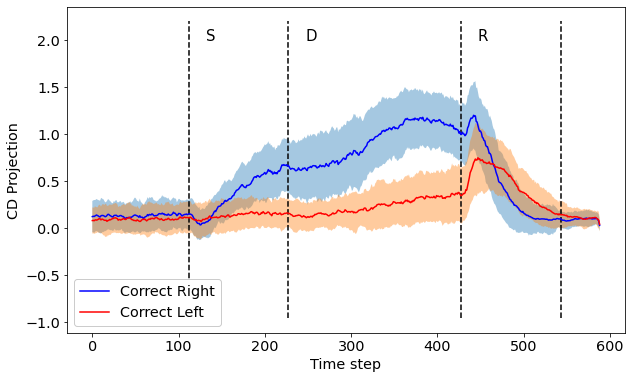

In [13]:
x = range(len(R_CD_mean))
plt.figure(figsize=(10,6))
plt.plot(R_CD_mean, label='Correct Right', color = 'blue')
plt.plot(L_CD_mean, label='Correct Left', color = 'red')
plt.fill_between(x,R_CD_mean-R_CD_std,R_CD_mean+R_CD_std, alpha = 0.4)
plt.fill_between(x,L_CD_mean-L_CD_std,L_CD_mean+L_CD_std, alpha = 0.4)
plt.vlines([start,delay,cue,lick], np.min(L_CD_mean)-1,np.max(R_CD_mean)+1, linestyles='dashed', color = 'black')
plt.xlabel('Time step')
plt.ylabel('CD Projection')
plt.text(start+20,2,'S',fontsize=15)
plt.text(delay+20,2,'D',fontsize=15)
plt.text(cue+20,2,'R',fontsize=15)
plt.legend(loc='lower left',framealpha=1)
plt.show()

In [14]:
def get_endpoints(filename):
    mat = scipy.io.loadmat('SiliconProbeData/FixedDelayTask/'+str(filename))
    delay_length = mat['unit'][0][0]['Behavior']['Cue_start'][0][0][0][0] - \
                   mat['unit'][0][0]['Behavior']['Delay_start'][0][0][0][0]
    #print('Delay: ',delay_length)
    if(delay_length < 2):
        print('Delay length: ',delay_lenght)
        print('Small delay \n file',filename,'skipped')
        return
    
    n_trials = len(mat['unit'][0][0]['Trial_info'][0][0][0][0])
    
    t_spike = [mat['unit'][0][i][0] for i in range(len(mat['unit'][0]))]
    id_trial = [mat['unit'][0][i][1] for i in range(len(mat['unit'][0]))]
    N = len(id_trial)
    
    def get_spike_rates(TrID):
        mask = [id_trial[i] == TrID for i in range(N)]
        masked_t_spike = [t_spike[i][mask[i]] for i in range(N)]
        
        trial_type = [mat['unit'][0][i]['Trial_info'][0][0][0][0][TrID-1][0] for i in range(N)]
        response = [mat['unit'][0][i]['Behavior']['Trial_types_of_response'][0][0][0][TrID-1][0] for i in range(N)]
    
        if(not all_equal(trial_type) or not all_equal(response)):
            print('ERROR')
    
            
        flattened_spikes = [i for j in range(N) for i in (masked_t_spike[j])]
        t_min = min(flattened_spikes)
        t_max = max(flattened_spikes)
        #print('First spike: ',t_min)
        #print('Last spike: ',t_max)
        T = t_max - t_min
    
        #spike_sort = np.sort(flattened_spikes)
        #mean_dt = np.mean([spike_sort[i+1]-spike_sort[i] for i in range(len(spike_sort)-1)])

        #print('Mean interspike time: ', mean_dt)
        start = mat['unit'][0][0]['Behavior']['Sample_start'][0][0][0][TrID-1]
        average_window = 0.1
        sliding = 0.01
        
        NT = int((T-average_window)/sliding)
        n_start = int((start-average_window)/sliding)
        #print(NT)
  
        activity = np.zeros(shape=(NT,N))
            
        for i in range(NT):
            spike_count = np.zeros(shape=(N))
            t = [i*sliding,i*sliding+average_window]
            for j in range(N):
                for k in masked_t_spike[j]:
                    if(t[0] <= k and t[1] > k):
                        spike_count[j] += 1
            spike_count = spike_count/average_window
            activity[i,:] = spike_count
        return activity[:,:]
    
    L_ID = []
    R_ID = []
    for i in range(n_trials):
        if mat['unit'][0][0]['Behavior']['Trial_types_of_response'][0][0][0][i][0]=='CR':
            R_ID.append(i+1)
        elif mat['unit'][0][0]['Behavior']['Trial_types_of_response'][0][0][0][i][0]=='CL':
            L_ID.append(i+1)
    #print('Correct left trials: ', len(L_ID))
    #print('Correct right trials: ', len(R_ID))
    
    dim = get_spike_rates(R_ID[0]).shape
    tensor_activity_L = np.zeros(shape=(dim[0],dim[1],len(L_ID)))
    tensor_activity_R = np.zeros(shape=(dim[0],dim[1],len(R_ID)))
    
    rm_idx_L = []
    rm_idx_R = []
    for i in range(len(L_ID)):
        try:
            tmp = get_spike_rates(L_ID[i])
            check_dim = tmp.shape
            if(check_dim[0] >= dim[0]):
                tensor_activity_L[:,:,i] = tmp[:dim[0],:]
            else:
                tensor_activity_L[:check_dim[0],:,i] = tmp
        except:
            rm_idx_L.append(i)
           
    for i in range(len(R_ID)):
        try:
            tmp = get_spike_rates(R_ID[i])
            check_dim = tmp.shape
            if(check_dim[0] >= dim[0]):
                tensor_activity_R[:,:,i] = tmp[:dim[0],:]
            else:
                tensor_activity_R[:check_dim[0],:,i] = tmp
        except:
            rm_idx_R.append(i)
            
    tensor_activity_L = np.delete(tensor_activity_L, rm_idx_L,axis=2)
    tensor_activity_R = np.delete(tensor_activity_R, rm_idx_R,axis=2)
    
    tensor_dim_L = tensor_activity_L.shape
    tensor_dim_R = tensor_activity_R.shape
    ## Trial
    id_left = np.random.randint(0,tensor_dim_L[2],int(tensor_dim_L[2]/2))
    id_right = np.random.randint(0,tensor_dim_R[2],int(tensor_dim_R[2]/2))
    mean_activity_L = np.mean(tensor_activity_L[:,:,id_left],axis=2)
    mean_activity_R = np.mean(tensor_activity_R[:,:,id_right],axis=2)
    
    w = mean_activity_R-mean_activity_L
    average_window = 0.1
    sliding = 0.01
    
    start = int((mat['unit'][0][0]['Behavior']['Sample_start'][0][0][0][L_ID[0]-1]-average_window)/sliding)
    delay = int((mat['unit'][0][0]['Behavior']['Delay_start'][0][0][0][L_ID[0]-1]-average_window)/sliding)
    cue = int((mat['unit'][0][0]['Behavior']['Cue_start'][0][0][0][L_ID[0]-1]-average_window)/sliding)
    lick = int((mat['unit'][0][0]['Behavior']['First_lick'][0][0][0][L_ID[0]-1]-average_window)/sliding)
    
    mean_w =np.mean(w[delay:cue],axis=0)
    mean_w.shape
    
    mean_w = mean_w/np.linalg.norm(mean_w)
    
    ## Test
    id_test_left = [i for i in range(tensor_dim_L[2]) if (i not in id_left)]
    id_test_right = [i for i in range(tensor_dim_R[2]) if (i not in id_right)]
    R_CD = [np.dot(mean_w,tensor_activity_R[i,:,j]) for i in range(len(mean_activity_R)) for j in  id_test_right]
    L_CD = [np.dot(mean_w,tensor_activity_L[i,:,j]) for i in range(len(mean_activity_L)) for j in  id_test_left]
    
    R_CD = np.reshape(np.array(R_CD),(len(tensor_activity_R[:,0,0]),len(tensor_activity_R[0,0,id_test_right])))
    L_CD = np.reshape(np.array(L_CD),(len(tensor_activity_L[:,0,0]),len(tensor_activity_L[0,0,id_test_left])))
    
    R_CD_mean = np.mean(R_CD, axis= 1)
    L_CD_mean = np.mean(L_CD, axis= 1)
    norm = R_CD_mean[cue]
    R_CD_std = np.std(R_CD, axis= 1)
    L_CD_std = np.std(L_CD, axis= 1)
    
    R_CD_end = R_CD/norm
    L_CD_end = L_CD/norm
    #print(R_CD_end.shape)
    return ([R_CD_end, L_CD_end,start,delay,cue,lick])

<font size="+1.5"><p style="text-align:center;">
The procedure is repeated for all sessions
</p></font>

In [15]:
data = np.load('all_CD.npy',allow_pickle=True)

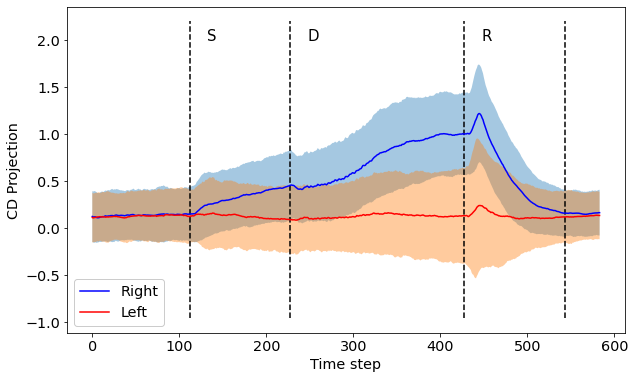

In [16]:
RCD_all = []
LCD_all = []
min_size_R = 1000
min_size_L = 1000
nd = 4
for i in range(len(filename)):
    if(i not in [9,16,17]):
        RCD_all.append(data[i][0])
        LCD_all.append(data[i][1])
        if(len(data[i][0]) < min_size_R):
            min_size_R = len(data[i][0])
        if(len(data[i][1]) < min_size_L):
            min_size_L = len(data[i][1])

RCD_all = np.array(RCD_all, dtype=object)
LCD_all = np.array(LCD_all, dtype=object)

for i in range(len(filename)-nd):
    LCD_all[i] = LCD_all[i][:min_size_L,:]
    RCD_all[i] = RCD_all[i][:min_size_R,:]
RCD_mean_all = RCD_all[0]
LCD_mean_all = LCD_all[0]

for i in range(1,len(filename)-nd):
    RCD_mean_all = np.concatenate((RCD_mean_all,RCD_all[i]),axis=1)
    LCD_mean_all = np.concatenate((LCD_mean_all,LCD_all[i]),axis=1)

RCD_std_all  = np.std(RCD_mean_all,axis=1)
LCD_std_all  = np.std(LCD_mean_all,axis=1)
RCD_mean_all  = np.mean(RCD_mean_all,axis=1)
LCD_mean_all  = np.mean(LCD_mean_all,axis=1)

x = range(len(RCD_mean_all))
plt.figure(figsize=(10,6))
plt.plot(x,RCD_mean_all, color = 'blue',label = 'Right')
plt.plot(x,LCD_mean_all, color = 'red',label = 'Left')
plt.fill_between(x,RCD_mean_all-RCD_std_all,RCD_mean_all+RCD_std_all, alpha = 0.4)
plt.fill_between(x,LCD_mean_all-LCD_std_all,LCD_mean_all+LCD_std_all, alpha = 0.4)
plt.vlines([start,delay,cue,lick], np.min(L_CD_mean)-1,np.max(R_CD_mean)+1, linestyles='dashed', color = 'black')
plt.xlabel('Time step')
plt.ylabel('CD Projection')
plt.text(start+20,2,'S',fontsize=15)
plt.text(delay+20,2,'D',fontsize=15)
plt.text(cue+20,2,'R',fontsize=15)
plt.legend(loc='lower left',framealpha=1)
plt.show()

<font size="+1.5"><p style="text-align:center;">
The distribution of the end points is extracted
</p></font>

In [39]:
cue_point_L = []
cue_point_R = []
for i in range(len(data)):
    if(i not in [9,16,17]):
        for j in list(data[i][1][data[i][4],:]) :
            cue_point_L.append(j)
    
for i in range(len(data)):
    if(i not in [9,16,17]):
        for j in list(data[i][0][data[i][4],:]) :
            cue_point_R.append(j)

In [40]:
cue_point_L = np.array(cue_point_L)
cue_point_R = np.array(cue_point_R)
mask_1_L = cue_point_L > -0.5
mask_2_L = cue_point_L < 2
mask_L = np.logical_and(mask_1_L,mask_2_L)
mask_1_R = cue_point_R > -0.5
mask_2_R = cue_point_R < 2
mask_R = np.logical_and(mask_1_R,mask_2_R)
cue_point_L = cue_point_L[mask_L]
cue_point_R = cue_point_R[mask_R]

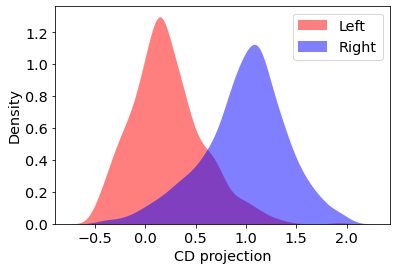

In [45]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.kdeplot(cue_point_L, fill=True, label = 'Left', color = 'red',linewidth=0, alpha = 0.5)
sns.kdeplot(cue_point_R, fill = True, label ='Right', color = 'blue', linewidth=0, alpha=0.5)
plt.xlabel('CD projection')
plt.legend()
plt.show()

<font size="+2"><p style="text-align:center;">Discrete attractor dynamics <br>
    and ramping activity </p></font>
    
   <center><img src=".\attractor.PNG" style="width: 30%; height: 50%;" /></center>
   <font size="+1.5"><p style="text-align:center;">Ramping dynamics in discrete attractor networks can be obtained by the tuning of network parameters to generate slow drift to the fixed points.</p></font>

$$\tau_i \frac{dh_i(t)}{dt} = -h_i(t) + \sum_{j=L,R}\widetilde{W}_{ij}G_E(h_j(t)) +\widetilde{I}^{non sel}_i(t) + I^{sel}_i(t) +\eta_i(t) $$

$$\widetilde{W}_{ij} = W_{ij} - \frac{W_{iI}W_{Ij}}{1+W_{II}}, \qquad \widetilde{I}^{non sel}_i(t) = I_E^{non sel}(t) - \frac{W_{iI}I_I^{non sel}}{1+W_{II}}  $$

$$G_E(h_i) = u_ix_ig_i\ \qquad \ g_i = g(h_i) $$


$$u_i = \frac{U + U\tau_f g_i}{1+U\tau_f g_i} \quad x_i = \frac{1}{1+u_i\tau_D g_i}$$


$$g_i = g(h_i) = k\ \text{log}(1+e^{h_i/k}) $$

In [47]:
def expsmooth(X, dt, tau):
    T = 1000*dt

    for n in range(1,len(X)):        
        X[n] = np.exp(-T/tau)*X[n-1] + (1-np.exp(-T/tau))*X[n]
    return X
            
def h_static(y,tauD,tauf,U):  
    h_out = (U + y*U*tauf)/(1 + y**2*U*tauD*tauf + y*U*(tauD + tauf));
    return h_out

In [69]:
#Network parameters

N_trials = 500

# Membrane time constant
tau_R = 100
tau_L = 100

dt = 1

t_end = 6000
t_vec = range(0,t_end,dt)

taus = [tau_R, tau_L]

bsln_t = 1500/dt
  
t_dur_stim = 1000/dt
t_dur_delay = 2000/dt

#sample epoch start and end (coincides with start of delay epoch)
t_stim_start = bsln_t + 1
t_stim_end = t_stim_start + t_dur_stim - 1

#End of Delay epoch
t_delay_end = t_stim_end + t_dur_delay

t_ramp_start = t_stim_start

#Value of alpha in the transduction function: 
#f(x) = alpha*log(1+exp(x/alpha))
alpha = 4.5

# Network connectivity and parameters 
network_str = 'one_hemi_multi_fp_step' 


if (network_str == 'one_hemi_multi_fp_step'):

    stim_sigma = 0.1 
    stim_amp = 0.8
    
    #amplitude of fast noise
    sigma_noise = 9 

    #synaptic weights
    jRR = 5.8
    jLL = jRR
    jRI = 5
    jIR = 1.08
    jLI = jRI
    jIL = jIR
    jRL = 0.9
    jLR = jRL
    jII = 2

    #input currents
    iR = 2.27 
    iL = iR 
    iI = 1 
    iI_bsl = iI 

    #static nonlinearity parameters
    tauD = 0.14 
    tauf = 0.8 
    U = 0.05 
    
    # Step-like ramp
    t_ramp_end = t_ramp_start + 10/dt
        
    # amplitude of ramping at the end of delay
    ramp_amp = 2


sim_len = int(t_end/dt) 
fs = 1000/dt 
tau_ext = 20 

stim_t = np.zeros(sim_len) 
stim_t[int(t_stim_start+1+int(tau_ext/dt)):int(t_stim_end-int(tau_ext/dt))] = 1

stim_smooth_vec = expsmooth(stim_t, fs, tau_ext) 

## ramping stimulus

Ramp_temp = ramp_amp/(len(range(int(t_ramp_start),int(t_ramp_end-1)))/1000)*np.array([1,1])

Ramp_vec = np.zeros((sim_len,2))
for t_idx in range(int(t_ramp_start),int(t_ramp_end)):  
    Ramp_vec[t_idx,:] = np.transpose(Ramp_temp)*(t_idx-t_ramp_start)/1000 
Ramp_vec[int(t_ramp_end):,:] = Ramp_vec[int(t_ramp_end-1),1]


## Dynamics
h_mat = np.zeros((N_trials,len(t_vec),2)) 
r_mat = np.zeros((N_trials,len(t_vec),2)) 

    
## Scaled weights

jRR = jRR - (jIR*jRI)/(1+jII) 
jLL = jLL - (jIL*jLI)/(1+jII) 
jRL = jRL - (jRI*jIL)/(1+jII) 
jLR = jLR - (jLI*jIR)/(1+jII) 
iR = iR - (jRI*iI)/(1+jII) 
iL = iL - (jLI*iI)/(1+jII) 


## Synaptic Matrix

p_matrix = np.array([jRR, jRL, jLR, jLL ]).reshape((2,2))

input_mat = np.zeros((2,int(t_end/dt),N_trials)) 

# Noise
noise_input = np.zeros((2,int(t_end/dt),N_trials)) 

In [70]:
for k_trial in range(N_trials):
    
    Stim_amp_distr = (stim_amp+stim_sigma*np.random.randn(1))
    stim_in = np.zeros((len(stim_smooth_vec),2))
    ramp_in = Ramp_vec
      
    if (k_trial <= N_trials/2):
        stim_in[:,0] = Stim_amp_distr*stim_smooth_vec # R trials
        if (network_str=='one_hemi_single_fp'):
                ramp_in[:,1] = 0;
    else:
        stim_in[:,1] = Stim_amp_distr*stim_smooth_vec # L trials
        if (network_str=='one_hemi_single_fp'):
                ramp_in[:,0] = 0;

    # dynamics
    y = np.zeros((sim_len,2)) 
    h = np.zeros((sim_len,2)) 
    r = np.zeros((sim_len,2)) 
    
    h[0,:] = [1,1] 
    for t_idx in range(int(t_end/dt)-1):          
        y[t_idx,:] = alpha*np.log(1+np.exp(h[t_idx,:]/alpha)) 
        noise_input[:,t_idx,k_trial] = sigma_noise*np.random.randn(2) 

        input_mat[:,t_idx,k_trial] = np.dot(p_matrix,(np.array([h_static(y[t_idx,:],tauD,tauf,U)*y[t_idx,:]])).transpose()).transpose() + \
                                     np.array(noise_input[:,t_idx,k_trial]) + np.array(stim_in[t_idx,:]) + ramp_in[t_idx,:]

        h[t_idx+1,:] = h[t_idx,:] + (-h[t_idx,:] + input_mat[:,t_idx,k_trial])/taus*dt            
        r[t_idx+1,:] = h_static(y[t_idx,:],tauD,tauf,U)*alpha*np.log(1+np.exp(h[t_idx,:]/alpha)) 

    ## store values
    h_mat[k_trial,:,:] = h 
    r_mat[k_trial,:,:] = r 

In [71]:
half = int(N_trials/2)

correct_trials_right = r_mat[:half,int(t_delay_end),0]>r_mat[:half,int(t_delay_end),1]
correct_trials_left =  r_mat[half:,int(t_delay_end),0]<r_mat[half:,int(t_delay_end),1]

idx_R = np.where(correct_trials_right)
idx_L = half + np.array(np.where(correct_trials_left))

activity_R = (np.mean(r_mat[idx_R,:,0][0],axis=0)-np.mean(r_mat[idx_R,:,1][0],axis=0))
activity_L = (np.mean(r_mat[idx_L,:,0][0],axis=0)-np.mean(r_mat[idx_L,:,1][0],axis=0))

r_CD = np.array([activity_R,activity_L])
CD_delay = np.mean(r_CD[:,(int(t_delay_end)-int(400/dt)):int(t_delay_end)],axis=1)
mean_w = CD_delay/np.linalg.norm(CD_delay)

R_CD = np.array([np.dot(mean_w,r_mat[i,:,:].transpose()) for i in idx_R[0]])
L_CD = np.array([np.dot(mean_w,r_mat[i,:,:].transpose()) for i in idx_L[0]])

R_CD_mean = np.mean(R_CD, axis=0)
R_CD_std  = np.std(R_CD, axis=0)
L_CD_mean = np.mean(L_CD,axis=0)
L_CD_std  = np.std(L_CD, axis=0)

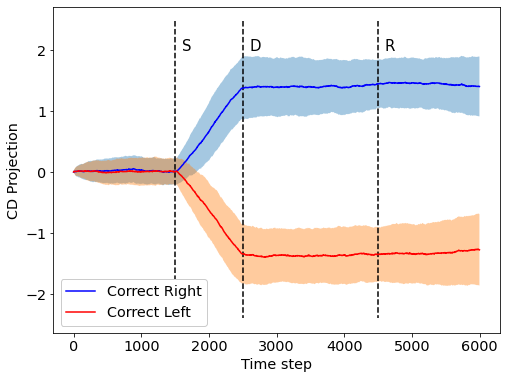

In [72]:
x = range(len(R_CD_mean))
plt.figure(figsize=(8,6))
plt.plot(R_CD_mean, label='Correct Right', color = 'blue')
plt.plot(L_CD_mean, label='Correct Left', color = 'red')
plt.fill_between(x,R_CD_mean-R_CD_std,R_CD_mean+R_CD_std, alpha = 0.4)
plt.fill_between(x,L_CD_mean-L_CD_std,L_CD_mean+L_CD_std, alpha = 0.4)
plt.vlines([t_stim_start,t_stim_end,t_delay_end],max(R_CD_mean)+1,min(L_CD_mean)-1, linestyles='dashed', color = 'black')
plt.xlabel('Time step')
plt.ylabel('CD Projection')
plt.text(t_stim_start+100,2,'S',fontsize=15)
plt.text(t_stim_end+100,2,'D',fontsize=15)
plt.text(t_delay_end+100,2,'R',fontsize=15)
plt.legend(loc='lower left',framealpha=1)
plt.show()

<font size="+2"><p style="text-align:center;">**FORCE learning**</p></font>
    
   <center><img src=".\force1.PNG" width="350" height="100"  /></center>
   
<font size="+1"><p style="text-align:center;">Internal synaptic modifications can be used to alter the chaotic activity <br>of a
recurrently connected neural network and generate complex but controlled outputs.</p></font>

<font size="+1"> **Two main problems** : </font>
<ol>
  <li><font size="+0.7">The synaptic modyfication can give rise to delayed effect that deviate the dynamics from the target.</font></li>
    <li><font size="+0.7">Training in face of chaotic spontaneous activity.</font></li>
</ol>

<font size="+1"><p style="text-align:center;">**The goal of training is not significant error
reduction, <br> but rather reducing the amount of modification needed to keep the errors small.** </p></font>

<div style="text-align: center;">
    <div style="display: inline-block; text-align: left;">
        <font size="+1">
            <b>F</b> irst <br>
            <b>O</b> order <br>
            <b>R</b> educed <br>
            <b>C</b> ontrolled <br>
            <b>E</b> rror
        </font>
    </div>
</div>

A learning algorithm suitable for FORCE learning must rapidly reduce the magnitude of the difference between the actual and desired output to a small value, and then keep it small while searching for and eventually finding a set of fixed synaptic weights that can maintain a small error without further modification.

### Recursive least squares algorithm (RLS)

$$e_{-} = \mathbf{J}^T(t-\Delta t)\ \vec{r}(t) - f(t) $$

$$\mathbf{J}(t) = \mathbf{J}^T(t-\Delta t) - e_{-}\textbf{P}(t)\vec{r}(t) $$

$$\textbf{P}(t) = \mathbf{P}(t-\Delta t)\ -\ \frac{\mathbf{P}(t-\Delta t)\ \vec{r}(t)\ \vec{r}^T(t)\ \mathbf{P}(t-\Delta t)}{1 + \vec{r}^T(t)\ \mathbf{P}(t-\Delta t)\ \vec{r}(t)},\qquad \text{where}\ \mathbf{P}(0) = \frac{\mathbf{I}}{\alpha} $$

In addition to dealing with feedback, FORCE learning must control the chaotic activity of the
network during the training process.

The input itself can induce a transition between chaotic and non-chaotic
states, provided that the given signal is of sufficient amplitude and frequency to induce a transition.

### Quick example

Simple firing rate model for the dynamics:

$$\tau \frac{\text{d}x_i}{\text{d}t} = - x_i + \sum_j^{N} J_{ij}\phi(x_j) + h_i $$

$$\phi(x) = \frac{1}{1+e^{-x}} $$

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [24]:
def firing_rates(x):
    r = 1/(1+np.exp(-x))
    return r

def network_vec(J,activity,I,tau):
    X_minus = activity
    X_plus = np.zeros((N,1))
    Jr = (J @ firing_rates(X_minus).reshape((N,1))).reshape(N)  
    X_plus = X_minus*(1-1/tau) + (Jr + I)/tau
    return X_plus

In [25]:
def freezed_white_noise(h0,tau_wn,in_T):
    eta = np.random.randn(in_T)
    wn = np.zeros(in_T)
    wn[0] = np.random.random()
    for i in range(1,in_T):
        wn[i] = wn[i-1]*(1-1/tau_wn) + h0*eta[i-1]/tau_wn
    return wn

In [26]:
# parameters
N = 100
pre_T = 50
in_T = 500
post_T = 50
T = pre_T+in_T+post_T
dt = 1
g = 1.5
tau = 10
sigma = g/math.sqrt(N)

np.random.seed(68)

J = np.random.randn(N,N)*sigma
for i in range(N):
    J[i,i] = 0

In [27]:
# Design of the External Inputs
I = np.zeros((N,T))
h0 = 1
tau_wn = 10
rep = 5
len_stim = int(in_T/rep)
for i in range(N):
        I[i,pre_T:pre_T+len_stim] = freezed_white_noise(h0,tau,len_stim)
for i in range(1,rep):
    I[:,pre_T+(i*len_stim):pre_T+((i+1)*len_stim)] = I[:,pre_T:pre_T+len_stim] 

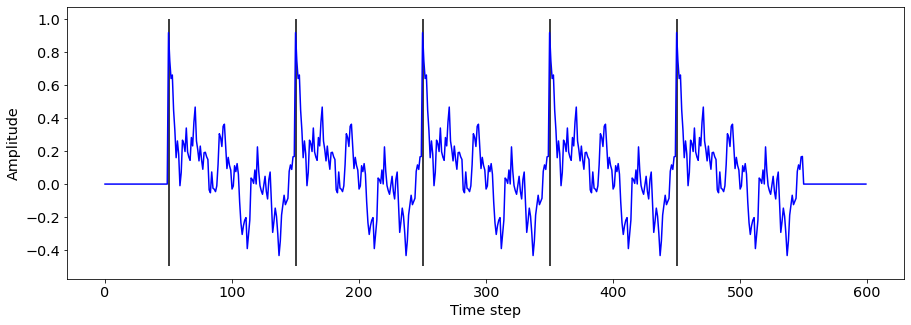

In [28]:
lines = [pre_T+(i*len_stim) for i in range(rep)]
plt.plot(I[0], color = 'blue')
plt.vlines([lines],1,-0.5,color='black')
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.show()

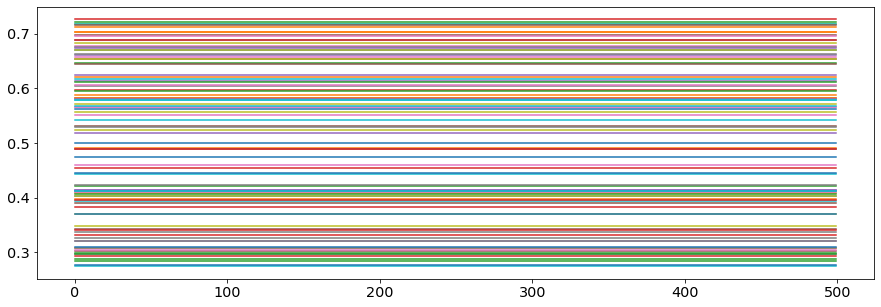

In [29]:
# Design of discrete attractor
f = np.zeros((N,in_T))
for i in range(N):
    f[i,:] = np.random.random()*2 - 1
    
plt.plot(firing_rates(f).T)
plt.show()

In [30]:
# FORCE
whole_activity = np.zeros((N,T))
alpha = N
trainable = N
trials = 5
J = np.random.randn(N,N)*sigma
J_init = np.copy(J)
P = np.identity(N)*alpha
i_idx = np.random.choice(range(N),trainable,replace=False)

for n_trials in range(trials): 
    I[:,:pre_T] = np.random.random((N,pre_T))
    
    whole_activity[:,0] = np.random.random(N)
    for ti in range(1,T):
        whole_activity[:,ti]=network_vec(J,whole_activity[:,ti-1],I[:,ti-1],tau)
        if(ti >= pre_T and ti < pre_T+in_T):
            r = firing_rates(whole_activity[:,ti]).reshape((N,1))
            r_prime = r.T
            z = J @ r
            e_minus = z - f[:,ti-pre_T].reshape((N,1))
            P = P - ((P @ r @ r_prime @ P)/(1 + (r_prime @ P @ r) ))
            c = 1/(1 + (r_prime @ P @ r) )
            Pr = P @ r
            deltaJ = c*(e_minus) @ Pr.T
            J[i_idx,:] = J[i_idx,:] - deltaJ[i_idx,:]
            e_plus = (J @ r) - f[:,ti-pre_T].reshape((N,1))
    #print('Trial ', n_trials+1)

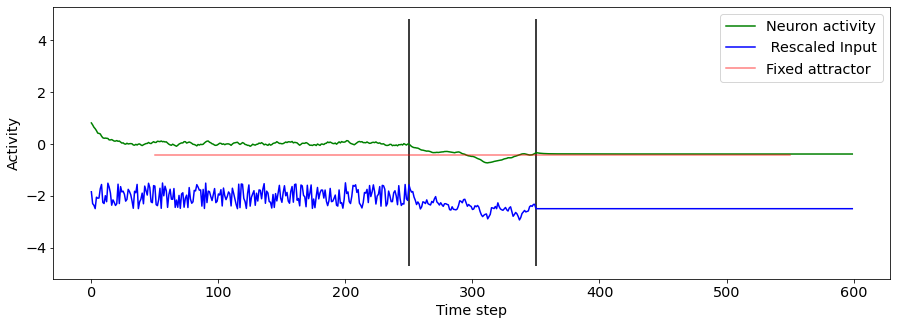

In [31]:
whole_activity[:,0] = np.random.random(N)
index = i_idx[1]
I[:,pre_T:pre_T+2*len_stim] = 0 
I[:,:pre_T+2*len_stim] = np.random.random((N,pre_T+2*len_stim))
I[:,pre_T+3*len_stim:] = 0
for ti in range(1,T):
    whole_activity[:,ti]=network_vec(J,whole_activity[:,ti-1],I[:,ti-1],tau)

plt.plot(whole_activity[index,:], color = 'green', label='Neuron activity')
plt.plot(I[0]-2.5, color = 'blue', label = ' Rescaled Input')
plt.vlines([pre_T+2*len_stim,pre_T+3*len_stim],min(whole_activity[index,:])-4,max(whole_activity[index,:])+4,color = 'black')
plt.plot(np.linspace(pre_T,pre_T+in_T,in_T),f[index,:],color='red',alpha = 0.5, label = 'Fixed attractor')
plt.xlabel('Time step')
plt.ylabel('Activity')
plt.legend()
plt.show()

## Real ALM data

In [32]:
L_f = np.load('rates_L.npy', allow_pickle=True)
R_f = np.load('rates_R.npy', allow_pickle=True)
pos = np.load('pos_unit.npy')

L_f = L_f[12]
R_f = R_f[12]

print(L_f.shape)
print(R_f.shape)

(589, 87)
(589, 87)


In [33]:
# Response design
N = len(L_f[0])
start_trial = pos[0]
input_trial = pos[1]
delay = pos[2]
cue_sig = 0
lw = 40
box = np.ones(lw)/lw
for i in range(len(L_f[0])):
    L_f[:,i] = L_f[:,i]/np.mean(L_f[:,i])
    R_f[:,i] = R_f[:,i]/np.mean(R_f[:,i])
    
    L_f[delay:,i] = L_f[delay,i]
    R_f[delay:,i] = R_f[delay,i]
    
    L_f[:,i] = np.convolve(L_f[:,i], box, mode='same')
    R_f[:,i] = np.convolve(R_f[:,i], box, mode='same')
    
L_f = L_f[:pos[2]+10,:]
R_f = R_f[:pos[2]+10,:]    


# for i in range(len(L_f[0])):   
#     L_f[:,i] = np.log(L_f[:,i]/(1-L_f[:,i]))
#     R_f[:,i] = np.log(R_f[:,i]/(1-R_f[:,i]))
# 
# del_R = np.unique(np.where(R_f <= -1E4)[1])
# del_L = np.unique(np.where(L_f <= -1E4)[1])
# 
# delete = np.unique(np.concatenate([del_R,del_L]))
# R_f =np.delete(R_f,delete,1)
# L_f =np.delete(L_f,delete,1)

### Selective cells

$$ \text{right selectivity}^{(i)} = \frac{r_{\text{right trial}}^i - r_{\text{left trial}}^i}{r_{\text{right trial}}^i + r_{\text{left trial}}^i} > \theta$$

$$ \text{left selectivity}^{(i)} = \frac{r_{\text{left trial}}^i - r_{\text{right trial}}^i}{r_{\text{left trial}}^i + r_{\text{right trial}}^i} > \theta$$

In [34]:
# selectivity
sel_R = []
sel_L = []
theta = 0.4
sel_value_data = []
for i in range(N):
    s = abs(L_f.T[i,pos[2]-1] + R_f.T[i,pos[2]-1])
    if(R_f.T[i,pos[2]-1] - L_f.T[i,pos[2]-1])/s > theta:
        sel_R.append(i)
    elif(L_f.T[i,pos[2]-1] - R_f.T[i,pos[2]-1])/s > theta:
        sel_L.append(i)
    sel_value_data.append(abs(L_f.T[i,pos[2]-1] - R_f.T[i,pos[2]-1])/s)
print('# Right selective neurons :',len(sel_R))
print('# Left selective neurons :',len(sel_L))
nonsel = []
for i in range(N):
    if((i not in sel_R) and i not in sel_L):
        nonsel.append(i)

# Right selective neurons : 11
# Left selective neurons : 6


### Selectivity index

$$\text{selectivity index} = \frac{1}{2}\left(\frac{\left< r_{r}^r\right> - \left<r_{l}^r\right>}{\left< r_{r}^r\right> + \left<r_{l}^r\right>} + \frac{\left< r_{l}^l\right> - \left<r_{r}^l\right>}{\left< r_{l}^l\right> + \left<r_{r}^l\right>}\right) $$

where $r_{r}^l$ is the spike rate of a **left** selective cell in **right** trials.

In [35]:
# selectivity_index
selctivity_index = 0

r_trial_r_pref = np.mean(R_f.T[sel_R,pos[2]-1])
l_trial_r_pref = np.mean(L_f.T[sel_R,pos[2]-1])
r_trial_l_pref = np.mean(R_f.T[sel_L,pos[2]-1])
l_trial_l_pref = np.mean(L_f.T[sel_L,pos[2]-1])

selectivity_index = 0.5*((r_trial_r_pref-l_trial_r_pref)/(r_trial_r_pref+l_trial_r_pref) + 
                         (l_trial_l_pref-r_trial_l_pref)/(l_trial_l_pref+r_trial_l_pref))

print('Selectivity index : ',selectivity_index)

Selectivity index :  0.5604197842948809


In [36]:
# Estimate of Real Data dimensionality
from sklearn.decomposition import PCA
avg_rrate = np.mean(R_f,axis=0)
QR = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        ri_diff = R_f[:,i]-avg_rrate[i]
        rj_diff = R_f[:,j]-avg_rrate[j]
        QR[i,j] = np.mean(ri_diff*rj_diff)
        
pca = PCA()
QR = pca.fit_transform(QR)
Qvar_R = np.cumsum(pca.explained_variance_ratio_)
print('Dimensionality for right trials :',np.where(Qvar_R >= 0.95)[0][0]+1)

avg_lrate = np.mean(L_f,axis=0)
QL = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        ri_diff = L_f[:,i]-avg_lrate[i]
        rj_diff = L_f[:,j]-avg_lrate[j]
        QL[i,j] = np.mean(ri_diff*rj_diff)

QL = pca.fit_transform(QL)
Qvar_L = np.cumsum(pca.explained_variance_ratio_)
print('Dimensionality for left trials :',np.where(Qvar_L >= 0.95)[0][0]+1)

Dimensionality for right trials : 2
Dimensionality for left trials : 1


In [37]:
# design of the two inputs
# silence (I) + L/R input (II) + common delay (III)

T = delay+cue_sig+50
L_seq = np.zeros((N,T))
R_seq = np.zeros((N,T))
redux = 10
cue_sig = 0

# II) L/R input
for i in range(N):
        L_seq[i,start_trial:input_trial] = freezed_white_noise(h0,tau,input_trial-start_trial)
        R_seq[i,start_trial:input_trial] = freezed_white_noise(h0,tau,input_trial-start_trial)
# III) common delay
        L_seq[i,input_trial:delay] = freezed_white_noise(h0,tau,delay-input_trial)
        R_seq[i,input_trial:delay] = L_seq[i,input_trial:+delay]

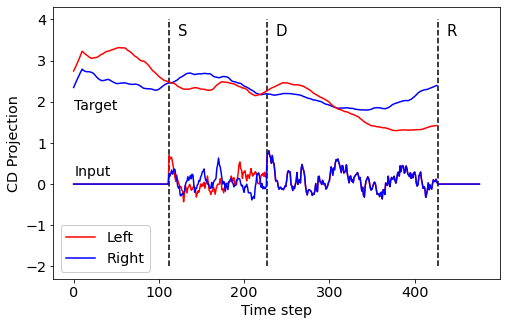

In [38]:
plt.figure(figsize=(8,5))
plt.plot(L_seq[0], color = 'red',label='Left')
plt.plot(R_seq[0],color = 'blue',label='Right')
plt.vlines(pos[:-1],-2,4,color='black', linestyles='dashed' )
plt.plot(R_f[10:,0]+1, color = 'blue')
plt.plot(L_f[10:,0]+1, color = 'red')
plt.xlabel('Time step')
plt.ylabel('CD Projection')
plt.text(1,1.8,'Target',fontsize=14)
plt.text(1,0.2, 'Input',fontsize=14)
plt.text(pos[0]+10,3.6,'S',fontsize=15)
plt.text(pos[1]+10,3.6,'D',fontsize=15)
plt.text(pos[2]+10,3.6,'R',fontsize=15)
plt.legend(loc='lower left',framealpha=1)
plt.show()

In [43]:
# FORCE
alpha = 10
trainable = N
trials = 12 # 50% Left
left_trials = np.random.choice(range(trials),int(trials/2),replace=False)
g = 1.5
sigma = g/math.sqrt(N)
J = np.random.randn(N,N)*sigma
J_init = np.copy(J)
i_idx = np.random.choice(range(N),trainable,replace=False)
whole_activity = np.zeros((N,T))
P = np.identity(N)*alpha
for n_trials in range(trials):
    #print('Trial ', n_trials+1)
    if(n_trials in left_trials):
        stim = L_seq
        f = L_f.T
        #print('Left')
    else:
        stim = R_seq
        f = R_f.T
        #print('Right')
        
    #stim[:,:start_trial] = np.random.random((N,start_trial))
    whole_activity[:,0] = np.random.random(N)
    
    for ti in range(1,T):
        whole_activity[:,ti]=network_vec(J,whole_activity[:,ti-1],stim[:,ti-1],tau)
        if(ti >= start_trial and ti < delay+cue_sig):
            r = firing_rates(whole_activity[:,ti]).reshape((N,1))
            r_prime = r.T
            z = J @ r
            e_minus = z - f[:,ti].reshape((N,1))
            P = P - ((P @ r @ r_prime @ P)/(1 + (r_prime @ P @ r) ))
            c = 1/(1 + (r_prime @ P @ r) )
            Pr = P @ r
            deltaJ = c*(e_minus) @ Pr.T
            J[i_idx,:] = J[i_idx,:] - deltaJ[i_idx,:]
            e_plus = (J @ r) - f[:,ti].reshape((N,1))

In [44]:
whole_activity_R = np.zeros((N,T))
whole_activity_R[:,0] = np.random.random(N)
#stim[:,:start_trial] = np.random.random((N,start_trial))
stim = R_seq
for ti in range(1,T):
    whole_activity_R[:,ti]=network_vec(J,whole_activity_R[:,ti-1],stim[:,ti-1],tau)


whole_activity_L = np.zeros((N,T))
whole_activity_L[:,0] = np.random.random(N)
stim = L_seq
for ti in range(1,T):
    whole_activity_L[:,ti]=network_vec(J,whole_activity_L[:,ti-1],stim[:,ti-1],tau)

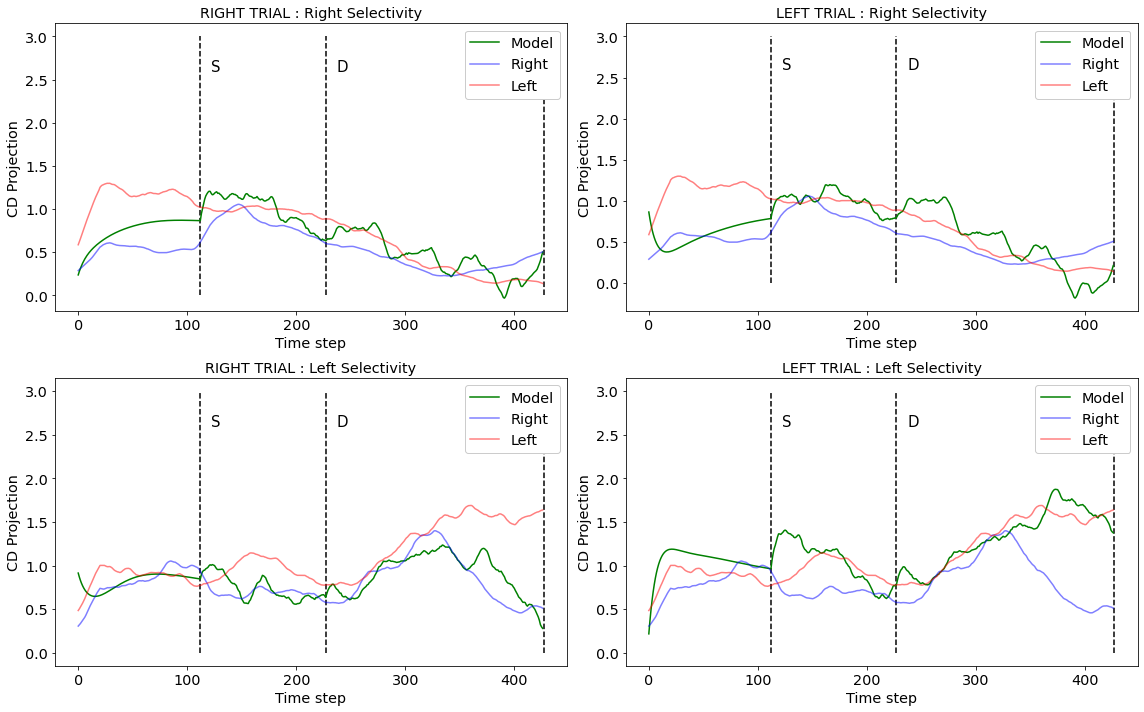

In [45]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.title('RIGHT TRIAL : Right Selectivity')
i_R = []
for i in i_idx:
    if(i in sel_R):
        i_R.append(i)
index = i_R[2]
plt.plot(whole_activity_R[index,:pos[2]], color = 'green',label = 'Model')
plt.plot(R_f.T[index,:pos[2]],color='blue', label = 'Right', alpha = .5)
plt.plot(L_f.T[index,:pos[2]],color='red', label = 'Left', alpha = .5)
plt.vlines(pos[0:3],0,3,color = 'black', linestyles='dashed')
plt.xlabel('Time step')
plt.ylabel('CD Projection')
plt.text(pos[0]+10,2.6,'S',fontsize=15)
plt.text(pos[1]+10,2.6,'D',fontsize=15)
plt.legend(framealpha=1)

plt.subplot(223)
plt.title('RIGHT TRIAL : Left Selectivity')
i_L = []
for i in i_idx:
    if(i in sel_L):
        i_L.append(i)
index = i_L[3]
plt.plot(whole_activity_R[index,:pos[2]], color = 'green', label = 'Model')
plt.plot(R_f.T[index,:pos[2]],color='blue', label = 'Right', alpha = .5)
plt.plot(L_f.T[index,:pos[2]],color='red', label = 'Left', alpha = .5)
plt.vlines(pos[0:3],0,3,color = 'black', linestyles='dashed')
plt.xlabel('Time step')
plt.ylabel('CD Projection')
plt.text(pos[0]+10,2.6,'S',fontsize=15)
plt.text(pos[1]+10,2.6,'D',fontsize=15)
plt.legend(framealpha=1)

plt.subplot(222)
plt.title('LEFT TRIAL : Right Selectivity')

i_R = []
for i in i_idx:
    if(i in sel_R):
        i_R.append(i)
index = i_R[2]
plt.plot(whole_activity_L[index,:pos[2]], color = 'green',label = 'Model')
plt.plot(R_f.T[index,:pos[2]],color='blue', label = 'Right', alpha = .5)
plt.plot(L_f.T[index,:pos[2]],color='red', label = 'Left', alpha = .5)
plt.vlines(pos[0:3],0,3,color = 'black', linestyles='dashed')
plt.xlabel('Time step')
plt.ylabel('CD Projection')
plt.text(pos[0]+10,2.6,'S',fontsize=15)
plt.text(pos[1]+10,2.6,'D',fontsize=15)
plt.legend(framealpha=1)

plt.subplot(224)
plt.title('LEFT TRIAL : Left Selectivity')
i_L = []
for i in i_idx:
    if(i in sel_L):
        i_L.append(i)
index = i_L[3]
plt.plot(whole_activity_L[index,:pos[2]], color = 'green', label = 'Model')
plt.plot(R_f.T[index,:pos[2]],color='blue', label = 'Right', alpha = .5)
plt.plot(L_f.T[index,:pos[2]],color='red', label = 'Left', alpha = .5)
plt.vlines(pos[0:3],0,3,color = 'black', linestyles='dashed')
plt.xlabel('Time step')
plt.ylabel('CD Projection')
plt.text(pos[0]+10,2.6,'S',fontsize=15)
plt.text(pos[1]+10,2.6,'D',fontsize=15)
plt.legend(framealpha=1)
plt.tight_layout()
plt.show()

np.save('Rsel', sel_R)
np.save('Lsel', sel_L)

In [209]:
type_wide = np.linspace(5,100,40)
i_idx_N = []
J_vec_N = []
both_trials = []
KL_R_all = []
KL_L_all = []
for how_much_learning in type_wide:
    #print('Learning with ',how_much_learning,' neurons')
    # FORCE learning
    alpha = 10
    trainable = int(N*how_much_learning/100)
    trials = 20 # 50% Left
    left_trials = np.random.choice(range(trials),int(trials/2),replace=False)
    g = 1.5
    sigma = g/math.sqrt(N)
    J = np.random.randn(N,N)*sigma
    J_init = np.copy(J)
    i_idx = np.random.choice(range(N),trainable,replace=False)
    i_idx_N.append(i_idx)
    
    whole_activity = np.zeros((N,T))
    P = np.identity(N)*alpha
    for n_trials in range(trials):
        #print('Trial ', n_trials+1)
        if(n_trials in left_trials):
            stim = L_seq
            f = L_f.T
        else:
            stim = R_seq
            f = R_f.T

        whole_activity[:,0] = np.random.random(N)
        
        for ti in range(1,T):
            whole_activity[:,ti]=network_vec(J,whole_activity[:,ti-1],stim[:,ti-1],tau)
            if(ti >= start_trial and ti < delay+cue_sig):
                r = firing_rates(whole_activity[:,ti]).reshape((N,1))
                r_prime = r.T
                z = J @ r
                e_minus = z - f[:,ti].reshape((N,1))
                P = P - ((P @ r @ r_prime @ P)/(1 + (r_prime @ P @ r) ))
                c = 1/(1 + (r_prime @ P @ r) )
                Pr = P @ r
                deltaJ = c*(e_minus) @ Pr.T
                J[i_idx,:] = J[i_idx,:] - deltaJ[i_idx,:]
                e_plus = (J @ r) - f[:,ti].reshape((N,1))
   
    NTrials = 100
    
    whole_activity_R_all = np.zeros((N,T,NTrials))
    for i in range(NTrials):
        whole_activity_R = whole_activity_R_all[:,:,i]
        whole_activity_R[:,0] = np.random.random(N)
        stim = R_seq
        for ti in range(1,T):
            whole_activity_R[:,ti]=network_vec(J,whole_activity_R[:,ti-1],stim[:,ti-1],tau)
        whole_activity_R_all[:,:,i] = whole_activity_R

    whole_activity_L_all = np.zeros((N,T,NTrials))
    for i in range(NTrials):
        whole_activity_L = whole_activity_L_all[:,:,i]
        whole_activity_L[:,0] = np.random.random(N)
        stim = L_seq
        for ti in range(1,T):
            whole_activity_L[:,ti]=network_vec(J,whole_activity_L[:,ti-1],stim[:,ti-1],tau) 
        whole_activity_L_all[:,:,i] = whole_activity_L
        
    whole_activity_R_mean = np.mean(whole_activity_R_all,axis=2) 
    whole_activity_L_mean = np.mean(whole_activity_L_all,axis=2) 
    
    r_trial = (whole_activity_R_mean[:,pos[2]-1])
    l_trial = (whole_activity_L_mean[:,pos[2]-1])
    both_trials.append([r_trial,l_trial])
    J_vec_N.append(J)   

### Distance measures

#### Mean difference

In [214]:
shuffle_idx = np.random.choice(range(N),N,replace=False)
diff_R = [np.mean(np.absolute(R_f.T[:,pos[2]-1] - both_trials[i][0]))/
          (np.mean(np.absolute(R_f.T[shuffle_idx,pos[2]-1] - both_trials[i][0]))) for i in range(len(type_wide))]
diff_L = [np.mean(np.absolute(L_f.T[:,pos[2]-1] - both_trials[i][1]))/
          np.mean(np.absolute(L_f.T[shuffle_idx,pos[2]-1] - both_trials[i][1])) for i in range(len(type_wide))]

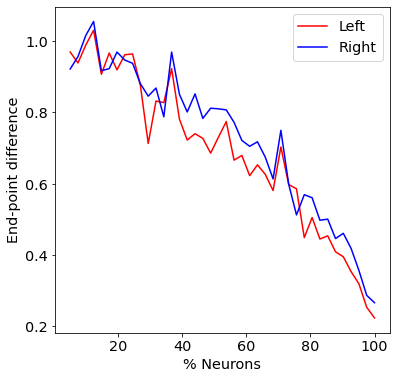

In [228]:
plt.figure(figsize=(6,6))
plt.plot(type_wide,diff_L, color = 'red', label = 'Left')
plt.plot(type_wide,diff_R, color = 'blue', label = 'Right')
plt.ylabel('End-point difference')
plt.xlabel('% Neurons')
plt.legend()
plt.show()

#### Kullback-Liedberg divergence

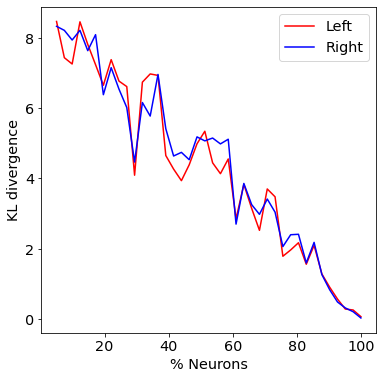

In [227]:
# KL divercence
KL_R = []
KL_L = []
plt.figure(figsize=(6,6))
for i in range(len(type_wide)):
    rate_R_model = both_trials[i][0]
    rate_R_model[rate_R_model <= 0] = 1e-8
    rate_R_data = R_f.T[:,pos[2]-1]
    rate_R_data[rate_R_data <= 0] = 1e-8
    rate_R_model = rate_R_model/sum(rate_R_model)
    rate_R_data = rate_R_data/sum(rate_R_data)
    KL_R.append(np.sum(rate_R_data*np.log(rate_R_data/rate_R_model)))

for i in range(len(type_wide)):
    rate_L_model = both_trials[i][1]
    rate_L_model[rate_L_model <= 0] = 1e-8
    rate_L_data = L_f.T[:,pos[2]-1]
    rate_L_data[rate_L_data <= 0] = 1e-8
    rate_L_model = rate_L_model/sum(rate_L_model)
    rate_L_data = rate_L_data/sum(rate_L_data)
    KL_L.append(np.sum(rate_L_data*np.log(rate_L_data/rate_L_model)))
    
plt.plot(type_wide,KL_L, color = 'red', label = 'Left')
plt.plot(type_wide,KL_R, color = 'blue', label = 'Right')
plt.ylabel('KL divergence')
plt.xlabel('% Neurons')
plt.legend()
plt.show()

### Recovery of cell selectivity

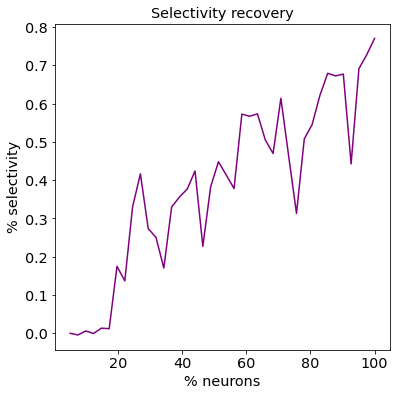

In [230]:
selectivity = []
np.array(both_trials)[np.array(both_trials) < 0] = 0
for i in range(len(type_wide)):    
    r_trial_r_pref = np.mean(both_trials[i][0][sel_R])
    l_trial_r_pref = np.mean(both_trials[i][1][sel_R])
    r_trial_l_pref = np.mean(both_trials[i][0][sel_L])
    l_trial_l_pref = np.mean(both_trials[i][1][sel_L])

    selectivity.append(0.5*((r_trial_r_pref-l_trial_r_pref)/(r_trial_r_pref+l_trial_r_pref) + 
                             (l_trial_l_pref-r_trial_l_pref)/(l_trial_l_pref+r_trial_l_pref)))

plt.figure(figsize=(6,6))
plt.plot(type_wide,selectivity/selectivity_index, color = 'purple')
plt.title('Selectivity recovery')
plt.xlabel('% neurons')
plt.ylabel('% selectivity')
plt.show()